# Descripció del cristall de BN

```{note}
En este notebook va la major part del codi. De fet és on estan tots els càlculs.
```

In [1]:
# Netejem totes les variables 
reset()

```{note}
En firefox cambiar "Math Renderer a Mathml" per visualitzar millor tant la web com el notebook, pulsant amb el botó dret del ratoli sobre qualsevol de les equacions.
```

In [2]:
# Eixida per defecte en LaTeX. 
%display latex

# Importe les biblioteques i mètodes que empre al llarg de l'script
from pylab import loadtxt
import pandas as pd

import numpy as np
from numpy import arange
#from myst_nb import glue

# Constants emprades
from periodictable import C, B, N, constants
u=constants.atomic_mass_constant*10**3 #para que este en CGS (y las const. de fuerza en dyn)

from scipy.constants import c

# Defineisc algunes funcions que empraré més endavant
def matriu_simplificada(matriu,m,n):
    matsimp=matriu
    for i in range(m):
        for j in range(n):
             matsimp[i,j]=matriu[i,j].full_simplify()
    
    return matsimp

Donat que el càlcul dels modes de vibració comença per establir la geomeria del cristall en equilibri, comprobem que el $BN$ monocapa es tracta d'un cristall bidimensional hexagonal de base diatómica la cel·la unitat del qual ve donada per (dades proporcionades):

$$
\vec a_1=a(1,0);\qquad\vec a_2=a\left(-\frac{1}{2},\frac{\sqrt{3}}{2}\right);
$$

In [3]:
var('a', domain='positive')
a_1=a*vector([1,0])
a_2=a*vector([-1/2,sqrt(3)/2])

Comprobem que efectivament els dos vectors base formen un angle de

In [4]:
angle=arccos(a_1*a_2/(norm(a_1)*norm(a_2)))
#glue("angle_cela", angle, display=False)
show(angle, " radians")
#In-line text; {glue:}`angle`

2/3*pi ' radians'

Numerem les cel·les unitat amb un índex vectorial $\vec l=\left( l_1, l_2\right)$.


Les posicions dels nucs són $\vec R_{\vec l}=l_1\vec{a}_1+l_2\vec{a}_2$<p>
Visualitzem una regió de la xarxa hexagonal, amb els corresponents nucs (que no àtoms), així com la corresponent cel·la unitat,

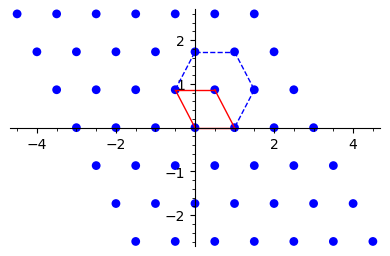

In [5]:
nucs=points([l_1*a_1/a+l_2*a_2/a for l_1 in range(-3, 4) for l_2 in range(-3,4)], 
             size=40, color="blue", frame=False)

xarxa=nucs+\
    line([(0,0),(a_1/a)],color="red")+\
     line([(0,0),(a_2/a)],color="red")+\
     line([(a_1/a),(a_1/a+a_2/a)],color="red")+\
     line([(a_2/a),(a_2/a+a_1/a)],color="red")+\
     line([(a_2/a),(a_1/a+2*a_2/a)],linestyle="--")+\
     line([(a_1/a+2*a_2/a),(2*a_1/a+2*a_2/a)],linestyle="--")+\
     line([(2*a_1/a+2*a_2/a),(2*a_1/a+a_2/a)],linestyle="--")+\
     line([(2*a_1/a+a_2/a),(a_1/a)],linestyle="--")

show(xarxa, figsize=4)

Les posicions atòmiques d'equilibri en la cel·la unitat són (també proporcionades com a dades):

$$
\vec R_B=\frac{1}{3}\vec{a_1}+2\vec{a_2}\qquad
\vec R_N=\frac{2}{3}\vec{a_1}+\frac{1}{3}\vec{a_2}
$$

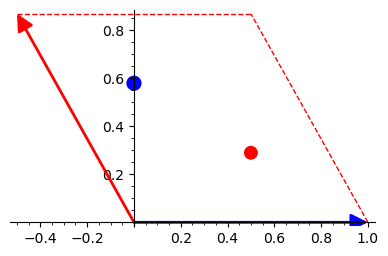

In [6]:
r_B=1/3*a_1+2/3*a_2; r_N=2/3*a_1+1/3*a_2
cela=arrow((0,0),(a_1/a),color="blue")+\
      arrow((0,0),(a_2/a),color="red")+\
      line([(a_1/a),(a_1/a+a_2/a)],linestyle="--",color="red")+\
      line([(a_2/a),(a_2/a+a_1/a)],linestyle="--",color="red")+\
      point(r_B/a, size=120,color="blue")+\
      point(r_N/a, size=100,color="red")

show(cela, frame=False, figsize=4)

## Identificació dels veins segons la seua distància

Per construir la matriu dinàmica necessitem com a pas previ classificar el átoms del cristall segons la seua distància als àtoms de la cel·la unitat, ja que els classificarem com primers, segons, tercers ... veïns segons aquesta distància i els assignarem un tensor de constants de forces que dependrá de a quina familia de veïns pertanyen.

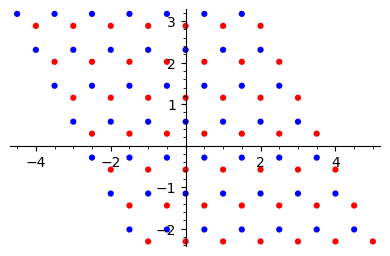

In [7]:
#Posicins d'equilibri dels àtoms en la cel·la (l1, l2)
def RB(l_1,l_2):
    return (l_1*a_1+l_2*a_2+r_B)

def RN(l_1,l_2):
    return (l_1*a_1+l_2*a_2+r_N)

AtomsB=points([RB(l_1,l_2)/a for l_1 in range(-3, 4) for l_2 in range(-3,4)],size=20,color='blue')
AtomsN=points([RN(l_1,l_2)/a for l_1 in range(-3, 4) for l_2 in range(-3,4)],size=20,color='red')

show(AtomsB+AtomsN, figsize=4)

In [8]:
var('q_x, q_y',domain='positive'); q=vector([q_x,q_y])


## Paràmetres de la xarxa, de la cel·la i del cristall

## Vector R_l (vector de translació primitiu)
def R_l(l_1,l_2):
    return l_1*a_1+l_2*a_2

## Vector de posició dels àtomos del cristall (en equilibri)
def R_alpha_l(alpha,l_1,l_2):
    if alpha == 1:
        return l_1*a_1+l_2*a_2+r_B

    elif alpha == 2:
        return l_1*a_1+l_2*a_2+r_N

    else:
        print("Error, alpha sols pot ser 1 o 2 ")

## Vector unitari que uneix un l'àtoms alphaprima de (0,0), amb l'àtom considerat (alpha, l_1,l_2)
def R_hat(alphaprima,alpha,l_1,l_2):
    if (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprima,0,0)).norm()>0:
        return (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprima,0,0))/(R_alpha_l(alpha,l_1,l_2)\
                                                                 -R_alpha_l(alphaprima,0,0)).norm()
    else:
        return (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprima,0,0))

# Distància entre l'àtom alphaprima i el seu veï (alpha, l_1,l_2)
def distancia(alphaprima,alpha,l_1,l_2):
    return (R_alpha_l(alpha,l_1,l_2)-R_alpha_l(alphaprima,0,0)).norm()/a    

#Fase per poder calcular la matriu dinàmica, notar que emprem R_l, no R_alpha_l
def fase(l_1,l_2):
    return exp(I*q*R_l(l_1,l_2))

#Genere una llista amb la distància de cada àtom als àtoms de la cel·la unitat 
def valors_atoms(l_1, l_2):
    return [(k, m, i, j, R_hat(k, m, i, j), distancia(k,m,i,j)) for k in [1,2] for m in [1,2]  \
      for i in range(-l_1,l_1+1) for j in range(-l_2,l_2+1)]

## Construisc un DataFrame de pandas amb la informació necessaria per identificar els 1ers, 2ons, ... veïns
## segons la seua distància a cadascun del àtoms de la cel·la unitat, per comprobar que la classificació es
## correcta
columnes = [r"$\alpha\prime$",r"$\alpha$",r"$l_1$", r"$l_2$", r"$\hat R$",'Distància']

def llista_atoms(l_1, l_2):
    return pd.DataFrame(valors_atoms(l_1,l_2),columns=columnes).sort_values(['Distància',r"$\alpha\prime$"],\
                                                                            ascending=[True,True])

## Mostre el dataframe como una taula per comprobar els càlculs
table(llista_atoms(2,2).to_html(index=False))

,,,,,Distància
1,1,0,0,"[0, 0]",0
2,2,0,0,"[0, 0]",0
1,2,-1,0,"[-3/2*sqrt(1/3), -1/2*sqrt(3)*sqrt(1/3)]",sqrt(1/3)
1,2,0,0,"[3/2*sqrt(1/3), -1/2*sqrt(3)*sqrt(1/3)]",sqrt(1/3)
1,2,0,1,"[0, sqrt(3)*sqrt(1/3)]",sqrt(1/3)
2,1,0,-1,"[0, -sqrt(3)*sqrt(1/3)]",sqrt(1/3)
2,1,0,0,"[-3/2*sqrt(1/3), 1/2*sqrt(3)*sqrt(1/3)]",sqrt(1/3)
2,1,1,0,"[3/2*sqrt(1/3), 1/2*sqrt(3)*sqrt(1/3)]",sqrt(1/3)
1,1,-1,-1,"[-1/2, -1/2*sqrt(3)]",1
1,1,-1,0,"[-1, 0]",1


## Tensor de constants de forca i matriu dinàmica

Construisc el tensor de constants de forces, així com la matriu dinàmica "a capes".
Notar que la contribució a la matriu dinàmica, en les submatrius de la diagonal, les que impliquen elements de la mateixa subxarxa que el ($\alpha', 0$), obtenim la contribució dinàmica d'este element a partir de la invariança a traslacions del cristall com un tot

In [9]:
#Angle que forma l'àtom considerat respecte a l'eix x

def angle(alphaprima,alpha,l_1,l_2):
    if R_hat(alphaprima,alpha,l_1,l_2)[1] <0:
        return -acos(R_hat(alphaprima,alpha,l_1,l_2)*vector([1,0]))
    
    else:
        return acos(R_hat(alphaprima,alpha,l_1,l_2)*vector([1,0]))

#Matriu unitària de rotació per al canvi d'eixos coordenats (entorn al'eix z)

def U(theta):
    return matrix([[cos(theta),sin(theta),0], [-sin(theta), cos(theta),0],[0,0,1]])

#Matriu de força per als primers veïns

var('M_B,M_N', domain='positive')
var('omega')

phi1rBN=var('phi1rBN',latex_name='\\phi_{1,r}^{BN}',domain='real')
phi1tiBN=var('phi1tiBN',latex_name='\\phi_{1,ti}^{BN}',domain='real')
phi1toBN=var('phi1toBN',latex_name='\\phi_{1,to}^{BN}',domain='real')

phi1rNB=phi1rBN; phi1tiNB=phi1tiBN; phi1toNB=phi1toBN


Phi_10__BN=1/sqrt(M_B*M_N)*Matrix([[phi1rBN,0,0],[0,phi1tiBN,0],[0,0,phi1toBN]])
Phi_10__NB=1/sqrt(M_N*M_B)*Matrix([[phi1rNB,0,0],[0,phi1tiNB,0],[0,0,phi1toNB]])


def Phi_1l__BN(alphaprima,alpha,l_1,l_2):
    return U(-angle(alphaprima,alpha,l_1,l_2))*Phi_10__BN*\
           U(angle(alphaprima,alpha,l_1,l_2))

def Phi_1l__NB(alphaprima,alpha,l_1,l_2):
    return U(-angle(alphaprima,alpha,l_1,l_2))*Phi_10__NB*\
           U(angle(alphaprima,alpha,l_1,l_2))

def D_1l_BN(alphaprima,alpha,l_1,l_2):
    return Phi_1l__BN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_1l_NB(alphaprima,alpha,l_1,l_2):
    return Phi_1l__NB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

# Matri de força per als segons veïns

phi2rBB=var('phi2rBB',latex_name='\\phi_{2,r}^{BB}',domain='real')
phi2tiBB=var('phi2tiBB',latex_name='\\phi_{2,ti}^{BB}',domain='real')
phi2toBB=var('phi2toBB',latex_name='\\phi_{2,to}^{BB}',domain='real')

phi2rNN=var('phi2rNN',latex_name='\\phi_{2,r}^{NN}',domain='real')
phi2tiNN=var('phi2tiNN',latex_name='\\phi_{2,ti}^{NN}',domain='real')
phi2toNN=var('phi2toNN',latex_name='\\phi_{2,to}^{NN}',domain='real')

Phi_20__BB=1/M_B*Matrix([[phi2rBB,0,0],[0,phi2tiBB,0],[0,0,phi2toBB]])
Phi_20__NN=1/M_N*Matrix([[phi2rNN,0,0],[0,phi2tiNN,0],[0,0,phi2toNN]])

def Phi_2l__BB(alphaprima,alpha,l_1,l_2):
    return U(-angle(alphaprima,alpha,l_1,l_2))*Phi_20__BB*\
           U(angle(alphaprima,alpha,l_1,l_2))

def Phi_2l__NN(alphaprima,alpha,l_1,l_2):
    return U(-angle(alphaprima,alpha,l_1,l_2))*Phi_20__NN*\
           U(angle(alphaprima,alpha,l_1,l_2))

def D_2l_BB(alphaprima,alpha,l_1,l_2):
    return Phi_2l__BB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_2l_NN(alphaprima,alpha,l_1,l_2):
    return Phi_2l__NN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)


#Matriu de força per als tercers veïns

phi3rBN=var('phi3rBN',latex_name='\\phi_{3,r}^{BN}',domain='real')
phi3tiBN=var('phi3tiBN',latex_name='\\phi_{3,ti}^{BN}',domain='real')
phi3toBN=var('phi3toBN',latex_name='\\phi_{3,to}^{BN}',domain='real')
phi3rNB,phi3tiNB,phi3toNB=phi3rBN,phi3tiBN,phi3toBN
Phi_30__BN=1/sqrt(M_B*M_N)*Matrix([[phi3rBN,0,0],[0,phi3tiBN,0],[0,0,phi3toBN]])
Phi_30__NB=1/sqrt(M_N*M_B)*Matrix([[phi3rNB,0,0],[0,phi3tiNB,0],[0,0,phi3toNB]])
                   
def Phi_3l__BN(alphaprima,alpha,l_1,l_2):
    return U(-angle(alphaprima,alpha,l_1,l_2))*Phi_30__BN*\
           U(angle(alphaprima,alpha,l_1,l_2))

def Phi_3l__NB(alphaprima,alpha,l_1,l_2):
    return U(-angle(alphaprima,alpha,l_1,l_2))*Phi_30__NB*\
           U(angle(alphaprima,alpha,l_1,l_2))

def D_3l_BN(alphaprima,alpha,l_1,l_2):
    return Phi_3l__BN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_3l_NB(alphaprima,alpha,l_1,l_2):
    return Phi_3l__NB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

#Matriu de força per als quart veïns
phi4rBN=var('phi4rBN',latex_name='\\phi_{4,r}^{BN}',domain='real')
phi4tiBN=var('phi4tiBN',latex_name='\\phi_{4,ti}^{BN}',domain='real')
phi4toBN=var('phi4toBN',latex_name='\\phi_{4,to}^{BN}',domain='real')
phi4rNB,phi4tiNB,phi4toNB=phi4rBN,phi4tiBN,phi4toBN

Phi_40__BN=1/sqrt(M_B*M_N)*Matrix([[phi4rBN,0,0],[0,phi4tiBN,0],[0,0,phi4toBN]])
Phi_40__NB=1/sqrt(M_N*M_B)*Matrix([[phi4rNB,0,0],[0,phi4tiNB,0],[0,0,phi4toNB]])

def Phi_4l__BN(alphaprima,alpha,l_1,l_2):
    return U(-angle(alphaprima,alpha,l_1,l_2))*Phi_40__BN*\
           U(angle(alphaprima,alpha,l_1,l_2))

def Phi_4l__NB(alphaprima,alpha,l_1,l_2):
    return U(-angle(alphaprima,alpha,l_1,l_2))*Phi_40__NB*\
           U(angle(alphaprima,alpha,l_1,l_2))

def D_4l_BN(alphaprima,alpha,l_1,l_2):
    return Phi_4l__BN(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

def D_4l_NB(alphaprima,alpha,l_1,l_2):
    return Phi_4l__NB(alphaprima,alpha,l_1,l_2)*fase(l_1,l_2)

# Finalmente construimos la matriz dinámica "a capas"
# Con la tabla de la celda de codigo anterior comprobamos que para considerar 
# hasta los cuartos vecinos es suficiente con l_1,l_2=2
                   
D1BN, D1NB, D2BB, D2NN, D3BN, D3NB, D4BN, D4NB = (matrix(3) for i in range(8))
D01BN, D01NB, D02BB, D02NN, D03BN, D03NB, D04BN, D04NB= (matrix(3) for i in range(8))
for k in [1,2]:
    for m in [1,2]:
         for i in range(-2,3):
            for j in range(-2,4):
                if (k==1) & bool( distancia(k,m,i,j) == sqrt(3)/3 ):
                    D1BN += D_1l_BN(k,m,i,j)
                    D01BN += Phi_1l__BN(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == sqrt(3)/3 ):
                    D1NB += D_1l_NB(k,m,i,j)
                    D01NB += Phi_1l__NB(k,m,i,j)
                 
                elif (k==1) & bool( distancia(k,m,i,j) == 1):
                    D2BB += D_2l_BB(k,m,i,j)
                    D02BB += Phi_2l__BB(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == 1):
                    D2NN += D_2l_NN(k,m,i,j)
                    D02NN += Phi_2l__NN(k,m,i,j)

                elif (k==1) & bool( distancia(k,m,i,j) == 2*sqrt(3)/3 ):
                    D3BN += D_3l_BN(k,m,i,j)
                    D03BN += Phi_3l__BN(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == 2*sqrt(3)/3 ):
                    D3NB += D_3l_NB(k,m,i,j)
                    D03NB += Phi_3l__NB(k,m,i,j)
                    
                elif (k==1) & bool( distancia(k,m,i,j) == sqrt(7/3)):
                    D4BN += D_4l_BN(k,m,i,j)
                    D04BN += Phi_4l__NB(k,m,i,j)

                elif (k==2) & bool( distancia(k,m,i,j) == sqrt(7/3)):
                    D4NB += D_4l_NB(k,m,i,j)
                    D04NB += Phi_4l__NB(k,m,i,j)


# Tenint en compte que la contribució a la matriu dinàmica dels àtoms situats en la cel·la 0 l'obtenim de la condició d'estabilitat

D2BB3ers=D2BB-D01BN-D02BB-D03BN
D2NN3ers=D2NN-D01NB-D02NN-D03NB

D2BB4ts=D2BB-D01BN-D02BB-D03BN-D04BN
D2NN4ts=D2NN-D01NB-D02NN-D03NB-D04NB

# Definim les variables que fan referencia a les freqüencies 
omegaGammaZA=var('omegaGammaZA',latex_name='\\omega(\\Gamma)_{ZA}',domain='positive')
omegaGammaTA=var('omegaGammaTA',latex_name='\\omega(\\Gamma)_{TA}',domain='positive')
omegaGammaLA=var('omegaGammaLA',latex_name='\\omega(\\Gamma)_{LA}',domain='positive')
omegaGammaZO=var('omegaGammaZO',latex_name='\\omega(\\Gamma)_{ZO}',domain='positive')
omegaGammaTO=var('omegaGammaTO',latex_name='\\omega(\\Gamma)_{TO}',domain='positive')
omegaGammaLO=var('omegaGammaLO',latex_name='\\omega(\\Gamma)_{LO}',domain='positive')

omegaMZA=var('omegaMZA',latex_name='\\omega(M)_{ZA}',domain='positive')
omegaMTA=var('omegaMTA',latex_name='\\omega(M)_{TA}',domain='positive')
omegaMLA=var('omegaMLA',latex_name='\\omega(M)_{LA}',domain='positive')
omegaMZO=var('omegaMZO',latex_name='\\omega(M)_{ZO}',domain='positive')
omegaMTO=var('omegaMTO',latex_name='\\omega(M)_{TO}',domain='positive')
omegaMLO=var('omegaMLO',latex_name='\\omega(M)_{LO}',domain='positive')

omegaKZA=var('omegaKZA',latex_name='\\omega(K)_{ZA}',domain='positive')
omegaKTA=var('omegaKTA',latex_name='\\omega(K)_{TA}',domain='positive')
omegaKLA=var('omegaKLA',latex_name='\\omega(K)_{LA}',domain='positive')
omegaKZO=var('omegaKZO',latex_name='\\omega(K)_{ZO}',domain='positive')
omegaKTO=var('omegaKTO',latex_name='\\omega(K)_{TO}',domain='positive')
omegaKLO=var('omegaKLO',latex_name='\\omega(K)_{LO}',domain='positive')

Tenim per tant que la matriu dinàmica serà una matriu $6x6$ hermítica. Però donat que les components en $z$ d'esta matriu es troben desacoblades podem tractar aquestes vibracions de manera independent.


## Vibracions fora de pla 
Donat que les vibracions fora de pla són, per com hem construït la matriu dinàmica, independients de les interplanars, procedim a estudiar-les, de manera que treballarem primer amb una matriu $2\times 2$, en compte de directament amb una matriu $6\times 6$ (i quan estudiem les vibracions dins del pla treballarem amb una matriu $4\times 4$

In [10]:
D1BN_zz=D1BN[2,2]
D1NB_zz=D1NB[2,2]

D2BB3ers_zz=D2BB3ers[2,2]
D2NN3ers_zz=D2NN3ers[2,2]

D2BB4ts_zz=D2BB4ts[2,2]
D2NN4ts_zz=D2NN4ts[2,2]

D3BN_zz=D3BN[2,2]
D3NB_zz=D3NB[2,2]
D4BN_zz=D4BN[2,2]
D4NB_zz=D4NB[2,2]

D_zz3ers=Matrix([[D2BB3ers_zz,D1BN_zz+D3BN_zz],        [D1NB_zz+D3NB_zz,D2NN3ers_zz]])

D_zz4ts=Matrix([[D2BB4ts_zz,D1BN_zz+D3BN_zz+D4BN_zz], [D1NB_zz+D3NB_zz+D4BN_zz,D2NN4ts_zz]])

### Primer considerem fins 3ers veïns

#### Punt $\Gamma$

Per al punt $(k_x=0, k_y=0)$, la matriu que tenim és:

In [11]:
omega_Gamma_ZO=832 #cm-1
omega_Gamma_ZA=0
D_Gamma3ers_zz=D_zz3ers.subs(q_x=0,q_y=0) #,(M_B,B.mass*u),(M_N,N.mass*u)])
show(D_Gamma3ers_zz)

[-3*phi1toBN/sqrt(M_B*M_N) - 3*phi3toBN/sqrt(M_B*M_N)  3*phi1toBN/sqrt(M_B*M_N) + 3*phi3toBN/sqrt(M_B*M_N)]
[ 3*phi1toBN/sqrt(M_B*M_N) + 3*phi3toBN/sqrt(M_B*M_N) -3*phi1toBN/sqrt(M_B*M_N) - 3*phi3toBN/sqrt(M_B*M_N)]

amb autovalors:

In [12]:
D_Gamma3ers_zz.eigenvalues()

[-6*(phi1toBN + phi3toBN)/sqrt(M_B*M_N), 0]

De manera que al punt $\Gamma$ trobem que s'ha de complir l'equació:

In [13]:
Eq_Gamma_ZO3ers=(D_Gamma3ers_zz.eigenvalues()[0]==omegaGammaZO**2)
show(Eq_Gamma_ZO3ers)

-6*(phi1toBN + phi3toBN)/sqrt(M_B*M_N) == omegaGammaZO^2

#### Punt $M$

Al punt $M$ $\left(q_x=\pi/a,q_y=\pi/(\sqrt 3 a\right)$ els valors propis de la matriu dinàmica són:

In [14]:
omega_M_ZO=638 #cm-1
omega_M_ZA=315

D_M3ers_zz=D_zz3ers.subs(q_x=pi/a,q_y=pi/(sqrt(3)*a))

# Podem simplificar un poc l'expressió obtessa per als valores propios al punto $M$ 
#(simplement reescribint l'argument de l'arrel quadrada)

omegaM1quadrat3ers=-4*phi2toBB/M_B-4*phi2toNN/M_N-3/sqrt(M_B*M_N)*(phi1toBN+phi3toBN)\
   -sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2)/(M_B*M_N)

if bool(D_M3ers_zz.eigenvalues()[0]==omegaM1quadrat3ers):
    Eq_M_ZA3ers=(omegaM1quadrat3ers==omegaMZA**2)



omegaM2quadrat3ers=-4*phi2toBB/M_B-4*phi2toNN/M_N-3/sqrt(M_B*M_N)*(phi1toBN+phi3toBN)\
   +sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2)/(M_B*M_N)

if bool(D_M3ers_zz.eigenvalues()[1]==omegaM2quadrat3ers):
    Eq_M_ZO3ers=(omegaM2quadrat3ers==omegaMZO**2)

Eq_M_ZOmesZA3ers=(Eq_M_ZO3ers+Eq_M_ZA3ers).subs(Eq_Gamma_ZO3ers.solve(phi3toBN)[0]).expand()
Eq_M_ZOmenysZA3ers_quadrat=((Eq_M_ZO3ers-Eq_M_ZA3ers)**2).subs(Eq_Gamma_ZO3ers.solve(phi3toBN)[0])

show(Eq_M_ZA3ers)
show(Eq_M_ZO3ers)

-3*(phi1toBN + phi3toBN)/sqrt(M_B*M_N) - 4*phi2toBB/M_B - 4*phi2toNN/M_N - sqrt(M_B*M_N*(phi1toBN - 3*phi3toBN)^2 + 16*(M_N*phi2toBB - M_B*phi2toNN)^2)/(M_B*M_N) == omegaMZA^2

-3*(phi1toBN + phi3toBN)/sqrt(M_B*M_N) - 4*phi2toBB/M_B - 4*phi2toNN/M_N + sqrt(M_B*M_N*(phi1toBN - 3*phi3toBN)^2 + 16*(M_N*phi2toBB - M_B*phi2toNN)^2)/(M_B*M_N) == omegaMZO^2

Notem que el segon valor propi és major que el primer (l'arrel quadrada és possitiva) i per tant correspon a la rama $ZO$, i el primer a $ZA$.

In [15]:
#D_M32ers_zz=D_zz3ers.subs(q_x=pi/(3*a),q_y=pi/(3*sqrt(3)*a))
#D_zz3ers.subs(q_x=4*pi/(9*a),q_y=0).eigenvalues()[0]

#D_M32ers_zz.eigenvalues()[0]

Podem observar que si considerem que les masses dels àtoms son iguals recuperem les expresions trobades per falkowsky_2008

In [16]:
show(Eq_M_ZO3ers.subs(M_B==M_N, phi2toNN=phi2toBB).expand())
show(Eq_M_ZA3ers.subs(M_B==M_N, phi2toNN=phi2toBB).expand())

-3*phi1toBN/M_N - 8*phi2toBB/M_N - 3*phi3toBN/M_N + abs(phi1toBN - 3*phi3toBN)/M_N == omegaMZO^2

-3*phi1toBN/M_N - 8*phi2toBB/M_N - 3*phi3toBN/M_N - abs(phi1toBN - 3*phi3toBN)/M_N == omegaMZA^2

#### Punt $K$

Per al punt ($q_x=4\pi/(3 a)$, $q_y=0$) obtenim els autovalors:

In [17]:
omega_K_ZO=602 #cm-1
omega_K_ZA=320
D_K_zz3ers=D_zz3ers.subs(q_x=4*pi/(3*a),q_y=0)

Eq_K_ZA3ers=(omegaKZA**2)==D_K_zz3ers.eigenvalues()[0].subs(Eq_Gamma_ZO3ers.solve(phi3toBN)[0]).expand()

Eq_K_ZO3ers=(omegaKZO**2==D_K_zz3ers.eigenvalues()[1]).subs(Eq_Gamma_ZO3ers.solve(phi3toBN)[0]).expand()

show(D_K_zz3ers)
show(Eq_K_ZA3ers)
show(Eq_K_ZO3ers)

[                                                                                          -3/2*phi2toBB*(I*sqrt(3) + 1)/M_B - 3/2*phi2toBB*(-I*sqrt(3) + 1)/M_B - 3*phi1toBN/sqrt(M_B*M_N) - 3*phi3toBN/sqrt(M_B*M_N) - 6*phi2toBB/M_B -1/2*phi1toBN*(I*sqrt(3) + 1)/sqrt(M_B*M_N) - 1/2*phi3toBN*(I*sqrt(3) + 1)/sqrt(M_B*M_N) - 1/2*phi1toBN*(-I*sqrt(3) + 1)/sqrt(M_B*M_N) - 1/2*phi3toBN*(-I*sqrt(3) + 1)/sqrt(M_B*M_N) + phi1toBN/sqrt(M_B*M_N) + phi3toBN/sqrt(M_B*M_N)]
[-1/2*phi1toBN*(I*sqrt(3) + 1)/sqrt(M_B*M_N) - 1/2*phi3toBN*(I*sqrt(3) + 1)/sqrt(M_B*M_N) - 1/2*phi1toBN*(-I*sqrt(3) + 1)/sqrt(M_B*M_N) - 1/2*phi3toBN*(-I*sqrt(3) + 1)/sqrt(M_B*M_N) + phi1toBN/sqrt(M_B*M_N) + phi3toBN/sqrt(M_B*M_N)                                                                                           -3/2*phi2toNN*(I*sqrt(3) + 1)/M_N - 3/2*phi2toNN*(-I*sqrt(3) + 1)/M_N - 3*phi1toBN/sqrt(M_B*M_N) - 3*phi3toBN/sqrt(M_B*M_N) - 6*phi2toNN/M_N]

omegaKZA^2 == 1/2*omegaGammaZO^2 - 9*phi2toNN/M_N

omegaKZO^2 == 1/2*omegaGammaZO^2 - 9*phi2toBB/M_B

Notem que en el cas del BN, a diferència del cas del grafè, obtenim 2 freqüenciès distintes al punt $K$ ja que la base està constituïda per dos àtoms d'elements distints (el segon terme d'ambdues equacions es diferent en este cas).
Tenim que tindre en compte que en aquest cas no sabem a priori a quina rama correspon cada valor propi, segons l'elecció que realitzem obtindrem els valors de les constants $\phi_{2,to}^{NN}$ i $\phi_{2,to}^{BB}$ intercambiades.

Observerm que les equacions per als modes al punt $K$ són formalment idèntiques a les que trobem en falkowski_2008 per al grafé, sols que en aquest cas, com estem tractant amb una base amb dos àtoms des distint tipus no tenim degeneració en este punt.

#### Constants de força
<b>Passem a resoldre el sistema d'equacions que hem obtés per obtindre les constants de força</b>:</p>
Tenim més equacions que incògnites, i segons les ecuacions escollides obtenim valors diferents. El sistema d'equacions que obtenim el podem resoldre, en este cas, tant analítica com numèricament.</p>

In [18]:
valors_numerics_emprats=[omegaGammaZO==omega_Gamma_ZO,omegaMZO==omega_M_ZO,omegaMZA==omega_M_ZA,\
                         omegaKZO==omega_K_ZO, omegaKZA==omega_K_ZA, M_B==B.mass, M_N==N.mass]

Per exemple, una solució analítica que trobem és:

In [19]:
solucions_perp3ers= solve([Eq_Gamma_ZO3ers,Eq_M_ZOmenysZA3ers_quadrat,Eq_K_ZO3ers,Eq_K_ZA3ers],\
                          phi1toBN,phi2toBB,phi2toNN,phi3toBN,algorithm="sympy")
show(solucions_perp3ers[0])
show(solucions_perp3ers[1])

{phi1toBN: -1/8*sqrt(M_B*M_N)*omegaGammaZO^2 - 1/72*sqrt(-(64*omegaKZA^4 - 128*omegaKZA^2*omegaKZO^2 + 64*omegaKZO^4 - 81*omegaMZA^4 + 162*omegaMZA^2*omegaMZO^2 - 81*omegaMZO^4)*M_B*M_N),
 phi2toBB: 1/18*(omegaGammaZO^2 - 2*omegaKZO^2)*M_B,
 phi2toNN: 1/18*(omegaGammaZO^2 - 2*omegaKZA^2)*M_N,
 phi3toBN: -1/24*sqrt(M_B*M_N)*omegaGammaZO^2 + 1/72*sqrt(-(64*omegaKZA^4 - 128*omegaKZA^2*omegaKZO^2 + 64*omegaKZO^4 - 81*omegaMZA^4 + 162*omegaMZA^2*omegaMZO^2 - 81*omegaMZO^4)*M_B*M_N)}

{phi1toBN: -1/8*sqrt(M_B*M_N)*omegaGammaZO^2 + 1/72*sqrt(-(64*omegaKZA^4 - 128*omegaKZA^2*omegaKZO^2 + 64*omegaKZO^4 - 81*omegaMZA^4 + 162*omegaMZA^2*omegaMZO^2 - 81*omegaMZO^4)*M_B*M_N),
 phi2toBB: 1/18*(omegaGammaZO^2 - 2*omegaKZO^2)*M_B,
 phi2toNN: 1/18*(omegaGammaZO^2 - 2*omegaKZA^2)*M_N,
 phi3toBN: -1/24*sqrt(M_B*M_N)*omegaGammaZO^2 - 1/72*sqrt(-(64*omegaKZA^4 - 128*omegaKZA^2*omegaKZO^2 + 64*omegaKZO^4 - 81*omegaMZA^4 + 162*omegaMZA^2*omegaMZO^2 - 81*omegaMZO^4)*M_B*M_N)}

In [20]:
show([(key, '=', round(value.subs(valors_numerics_emprats))) for key,value in solucions_perp3ers[0].items()])

[(phi1toBN, '=', -1377518),
 (phi2toBB, '=', -19570),
 (phi2toNN, '=', 379289),
 (phi3toBN, '=', -42181)]

Notem que en este cas hem emprat obtenim dues solucions diferent perque hem emprat una equació amb variables al quadrat, i la solució mostrada es la que millor s'ajusta a les dades proporcionades de les dos.<p>
Si escollim un altre conjunt d'equacions (sols canviem una):

In [21]:
solucions_perp3ers= solve([Eq_Gamma_ZO3ers,Eq_M_ZA3ers,Eq_K_ZO3ers,Eq_K_ZA3ers],\
                          phi1toBN,phi2toBB,phi2toNN,phi3toBN,algorithm="sympy")

show([(key, '=', round(value.subs(valors_numerics_emprats))) for key,value in solucions_perp3ers[0].items()])

[(phi1toBN, '=', -791210),
 (phi2toBB, '=', -19570),
 (phi2toNN, '=', 379289),
 (phi3toBN, '=', -628489)]

Les solucions anteriors les hem obtés resolguent algebraicament el sistema d'equacions. Ara el resoldrem numèricament (podríem fer ús de les funcions disponibles en *scipy.optimize*, per exemple, però sagemath ens proporciona la funció minimize directament).
El que faig es construir un vector les components del qual són les equacions que volem resoldre y minimitzar el seu mòdul:

In [22]:
Equacions3ers=[Eq_Gamma_ZO3ers.subs(valors_numerics_emprats),\
               Eq_M_ZA3ers.subs(valors_numerics_emprats),\
               Eq_K_ZO3ers.subs(valors_numerics_emprats),\
               Eq_K_ZA3ers.subs(valors_numerics_emprats)]

solucions3ers=minimize(norm(vector((Equacions3ers))),[1.,1.,1.,1.])

Solucions3ers=[phi1toBN==round(solucions3ers[0]), phi2toBB==round(solucions3ers[1]),\
               phi2toNN==round(solucions3ers[2]), phi3toBN==round(solucions3ers[3])]
Solucions3ers

[phi1toBN == -791210,
 phi2toBB == -19570,
 phi2toNN == 379289,
 phi3toBN == -628489]

Podem comprobar que obtenim la mateixa solució que si resolguem analíticament.
Així mateix, si emprem un altre sistema d'equacions les solucions són diferents:

In [23]:
Equacions3ers=[Eq_Gamma_ZO3ers.subs(valors_numerics_emprats),\
               Eq_M_ZO3ers.subs(valors_numerics_emprats),\
               Eq_K_ZO3ers.subs(valors_numerics_emprats),\
               Eq_K_ZA3ers.subs(valors_numerics_emprats)]

solucions3ers2=minimize(norm(vector((Equacions3ers))),[1.,1.,1.,1.])

Solucions3ers2=[phi1toBN==round(solucions3ers2[0]), phi2toBB==round(solucions3ers2[1]),\
                phi2toNN==round(solucions3ers2[2]), phi3toBN==round(solucions3ers2[3])]
Solucions3ers2

[phi1toBN == -715459,
 phi2toBB == -19570,
 phi2toNN == 379289,
 phi3toBN == -704240]

Realitzant diferents gràfiques podem comprobar que realment ajusta millor al conjunt de dades experimentals la primera solució que hem trobat, de manera que escollim com a conjunt de constants de força:

In [24]:
Equacions3ers=[2*Eq_Gamma_ZO3ers.subs(valors_numerics_emprats),\
               Eq_M_ZO3ers.subs(valors_numerics_emprats),\
               Eq_M_ZA3ers.subs(valors_numerics_emprats),\
               Eq_K_ZO3ers.subs(valors_numerics_emprats),\
               Eq_K_ZA3ers.subs(valors_numerics_emprats)]

solucions3ers=minimize(norm(vector((Equacions3ers))),[-1400000.,1.,1.,1.]) #[-1490000.,1.,1.,1.])

Solucions3ers=[phi1toBN==round(solucions3ers[0]), phi2toBB==round(solucions3ers[1]),\
                phi2toNN==round(solucions3ers[2]), phi3toBN==round(solucions3ers[3])]
Solucions3ers

[phi1toBN == -1379144,
 phi2toBB == -24085,
 phi2toNN == 373439,
 phi3toBN == -42723]

```{note}
En compte calcular els valors i vectors propis analíticament, ara que tenim tots els valors numérics  per construir la matriu de dispersió en cada punt, és molt més eficient convertir les matrius de sagemath en arrays de numpy, executant el mètode numpy sobre l'array en qüestió
```

In [25]:
dades=loadtxt("../Dades/freq.dat")
#data = pd.read_csv('../../Dades/freq.dat', header = None)
#show(pd.DataFrame(dades))

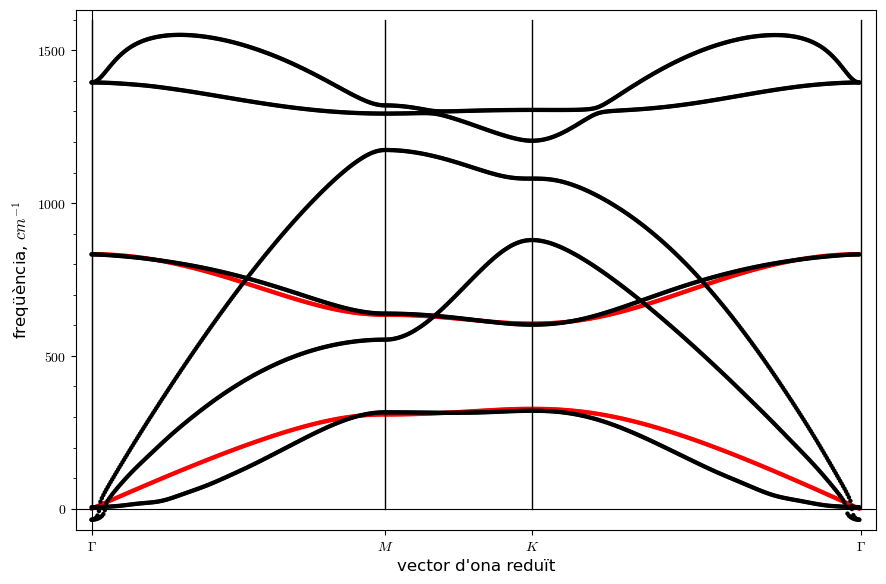

In [26]:
#Freqüències de Gamma a M (i les guardem com un dataframe). Calculem 200 punts en este interval
freq_perp_planol_Gamma_a_M=real_part(sqrt(np.linalg.eigvals(\
     np.array([D_zz3ers.subs(Solucions3ers, a=1, q_x=x/199*pi, q_y=x/199*pi/sqrt(3),\
                    M_B=B.mass, M_N=N.mass).numpy(dtype='complex64') for x in range(200)]))))

DF_freq_perp_planol_Gamma_a_M=pd.DataFrame(freq_perp_planol_Gamma_a_M)

#Freqüències de M a K (i les guardem com un dataframe). Calculem 100 punts en este interval
freq_perp_planol_M_a_K=real_part(sqrt(np.linalg.eigvals(\
     np.array([D_zz3ers.subs(Solucions3ers, a=1, q_x=pi*(1+x/(3*99)), q_y=pi/sqrt(3)*(1-x/99),\
                    M_B=B.mass, M_N=N.mass).numpy(dtype='complex64') for x in arange(100)]))))

DF_freq_perp_planol_M_a_K=pd.DataFrame(freq_perp_planol_M_a_K)

#Freqüències de K a Gamma (i les guardem com un dataframe). Calculem 124 punts en este interval
freq_perp_planol_K_a_Gamma=real_part(sqrt(np.linalg.eigvals(\
     np.array([D_zz3ers.subs(Solucions3ers, a=1, q_x=4*pi/3*(1-x/223), q_y=0,\
                    M_B=B.mass, M_N=N.mass).numpy(dtype='complex64') for x in range(224)]))))

DF_freq_perp_planol_K_a_Gamma=pd.DataFrame(freq_perp_planol_K_a_Gamma)

DF_freq_calculades_perp_planol=pd.concat([\
        DF_freq_perp_planol_Gamma_a_M,DF_freq_perp_planol_M_a_K,\
        DF_freq_perp_planol_K_a_Gamma],ignore_index=True)
DF_freq_calculades_perp_planol
DF_freq_calculades_perp_planol.to_csv("freq_calculades_perp_planol.dat", sep='\t', encoding='utf-8', header=False)

dades_calculades_perp_planol=loadtxt("freq_calculades_perp_planol.dat")
dispersioZ3ers=points(zip(dades_calculades_perp_planol[:200,0], dades_calculades_perp_planol[:200,1]), color="red")+\
points(zip(dades_calculades_perp_planol[:200,0], dades_calculades_perp_planol[:200,2]), color="red")+\
points(zip(dades_calculades_perp_planol[200:300,0], dades_calculades_perp_planol[200:300,1]), color="red")+\
points(zip(dades_calculades_perp_planol[200:300,0], dades_calculades_perp_planol[200:300,2]), color="red")+\
points(zip(dades_calculades_perp_planol[300:524,0], dades_calculades_perp_planol[300:524,1]), color="red")+\
points(zip(dades_calculades_perp_planol[300:524,0], dades_calculades_perp_planol[300:524,2]), color="red")+\
points(zip(dades[:524,0], dades[:524,1]), color="black") +\
points(zip(dades[524:1048,0], dades[524:1048,1]), color="black") +\
points(zip(dades[1048:1572,0], dades[1048:1572,1]), color="black") +\
points(zip(dades[1572:2096,0], dades[1572:2096,1]), color="black") +\
points(zip(dades[2096:2620,0], dades[2096:2620,1]), color="black") +\
points(zip(dades[2620:3144,0], dades[2620:3144,1]), color="black") +\
line([(0,0), (0,1600)],color="black")+\
line([(200,0), (200,1600)],color="black")+\
line([(300,0), (300,1600)],color="black")+\
line([(524,0), (524,1600)],color="black")
show(dispersioZ3ers,figsize=9,ticks=[[0,200,300,524],500], tick_formatter=[[r"$\Gamma$","$M$", "$K$",r"$\Gamma$"],500],\
     axes_labels=['vector d\'ona reduït','freqüència, $cm^{-1}$'],axes_labels_size=1.2, frame=True)

In [27]:
save(dispersioZ3ers,figsize=9,ticks=[[0,200,300,524],500], tick_formatter=[[r"$\Gamma$","$M$", "$K$",r"$\Gamma$"],500],\
     axes_labels=['vector d\'ona reduït','freqüència, $cm^{-1}$'],axes_labels_size=1.,frame=True, filename="/home/casimir/Documents/Fisica/TFG/TFG-Semiconductores_2D/Grafiques/DisZ3ers.pdf")

### Fins 4ts veïns

Si considerem fins als quarts veïns, també obtenim expresions analítiques per als valors propis de la matriu dinàmica als punts (de màxima simetria) considerats. Però en este cas no obtenim una solució analítica per al sistema d'equacions (sí trobem fàcilment solucions numéricament)

#### Punt $\Gamma$

In [28]:
D_Gamma4ts_zz=D_zz4ts.subs(q_x=0,q_y=0) #,(M_B,B.mass*u),(M_N,N.mass*u)])
D_Gamma4ts_zz.eigenvalues()
Eq_Gamma_ZO4ts=(D_Gamma4ts_zz.eigenvalues()[0]==omegaGammaZO**2)
show(Eq_Gamma_ZO4ts)

-6*(phi1toBN + phi3toBN + 2*phi4toBN)/sqrt(M_B*M_N) == omegaGammaZO^2

#### Punt $M$

In [29]:
D_M4ts_zz=D_zz4ts.subs(q_x=pi/a,q_y=pi/(sqrt(3)*a))

# Podem simplificar un poc l'expressió obtessa per als valores propios al punto $M$ 
#(simplement reescribint l'argument de l'arrel quadrada)

assume(sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2+\
         4*M_B*M_N*(phi1toBN-3*phi3toBN+phi4toBN)*phi4toBN)>0)

omegaM1quadrat4ts=-4*phi2toBB/M_B-4*phi2toNN/M_N-3/sqrt(M_B*M_N)*(phi1toBN+phi3toBN+2*phi4toBN)\
   -sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2+\
         4*M_B*M_N*(phi1toBN-3*phi3toBN+phi4toBN)*phi4toBN)/(M_B*M_N)

if bool(D_M4ts_zz.eigenvalues()[0]==omegaM1quadrat4ts):
    Eq_M_ZA4ts=(omegaM1quadrat4ts==omegaMZA**2)



omegaM2quadrat4ts=-4*phi2toBB/M_B-4*phi2toNN/M_N-3/sqrt(M_B*M_N)*(phi1toBN+phi3toBN+2*phi4toBN)\
   +sqrt(M_B*M_N*(phi1toBN-3*phi3toBN)^2+(4*(M_N*phi2toBB-M_B*phi2toNN))^2+\
         4*M_B*M_N*(phi1toBN-3*phi3toBN+phi4toBN)*phi4toBN)/(M_B*M_N)

if bool(D_M4ts_zz.eigenvalues()[1]==omegaM2quadrat4ts):
    Eq_M_ZO4ts=(omegaM2quadrat4ts==omegaMZO**2)
    
    
show(Eq_M_ZA4ts)
show(Eq_M_ZO4ts)

#Eq_M_ZOmesZA4ts=(Eq_M_ZO4ts+Eq_M_ZA4ts).subs(Eq_Gamma_ZO4ts.solve(phi4toBN)[0]).expand()
#show(Eq_M_ZOmesZA4ts)
#Eq_M_ZOmenysZA4ts_quadrat=((Eq_M_ZO4ts-Eq_M_ZA4ts)**2).subs(Eq_Gamma_ZO4ts.solve(phi4toBN)[0]).expand()
#show(Eq_M_ZOmenysZA4ts_quadrat)

-3*(phi1toBN + phi3toBN + 2*phi4toBN)/sqrt(M_B*M_N) - 4*phi2toBB/M_B - 4*phi2toNN/M_N - sqrt(M_B*M_N*(phi1toBN - 3*phi3toBN)^2 + 4*M_B*M_N*(phi1toBN - 3*phi3toBN + phi4toBN)*phi4toBN + 16*(M_N*phi2toBB - M_B*phi2toNN)^2)/(M_B*M_N) == omegaMZA^2

-3*(phi1toBN + phi3toBN + 2*phi4toBN)/sqrt(M_B*M_N) - 4*phi2toBB/M_B - 4*phi2toNN/M_N + sqrt(M_B*M_N*(phi1toBN - 3*phi3toBN)^2 + 4*M_B*M_N*(phi1toBN - 3*phi3toBN + phi4toBN)*phi4toBN + 16*(M_N*phi2toBB - M_B*phi2toNN)^2)/(M_B*M_N) == omegaMZO^2

#### Punt $K$

In [30]:
omega_K_ZO=602 #cm-1
omega_K_ZA=320
D_K_zz4ts=D_zz4ts.subs(q_x=4*pi/(3*a),q_y=0)

Eq_K_ZA4ts=(D_K_zz4ts.eigenvalues()[0]==omegaKZA**2).expand() #.subs(Eq_Gamma_ZO4ts.solve(phi4toBN)[0]).expand()
Eq_K_ZO4ts=(D_K_zz4ts.eigenvalues()[1]==omegaKZO**2).expand() #.subs(Eq_Gamma_ZO4ts.solve(phi4toBN)[0]).expand()

#Eq_K_ZOmesZA3ers=Eq_K_ZA3ers+Eq_K_ZO3ers

#Eq_K_ZOmenysZA3ers=Eq_K_ZA3ers-Eq_K_ZO3ers

show(Eq_K_ZA4ts)
show(Eq_K_ZO4ts)

-3*phi1toBN/(sqrt(M_B)*sqrt(M_N)) - 9*phi2toNN/M_N - 3*phi3toBN/(sqrt(M_B)*sqrt(M_N)) - 6*phi4toBN/(sqrt(M_B)*sqrt(M_N)) == omegaKZA^2

-3*phi1toBN/(sqrt(M_B)*sqrt(M_N)) - 9*phi2toBB/M_B - 3*phi3toBN/(sqrt(M_B)*sqrt(M_N)) - 6*phi4toBN/(sqrt(M_B)*sqrt(M_N)) == omegaKZO^2

In [31]:
Equacions4ts=[Eq_Gamma_ZO4ts.subs(valors_numerics_emprats),\
              Eq_M_ZO4ts.subs(valors_numerics_emprats),\
              Eq_M_ZA4ts.subs(valors_numerics_emprats),\
              Eq_K_ZO4ts.subs(valors_numerics_emprats),\
              Eq_K_ZA4ts.subs(valors_numerics_emprats)]
solucions4ts=minimize(norm(vector((Equacions4ts))),[-1485000.,1.,1.,1.,1.])
Solucions4ts=[phi1toBN==round(solucions4ts[0]), phi2toBB==round(solucions4ts[1]),\
              phi2toNN==round(solucions4ts[2]), phi3toBN==round(solucions4ts[3]),\
              phi4toBN==round(solucions4ts[4])]
Solucions4ts

[phi1toBN == -1463658,
 phi2toBB == -24083,
 phi2toNN == 373442,
 phi3toBN == -42438,
 phi4toBN == 42685]

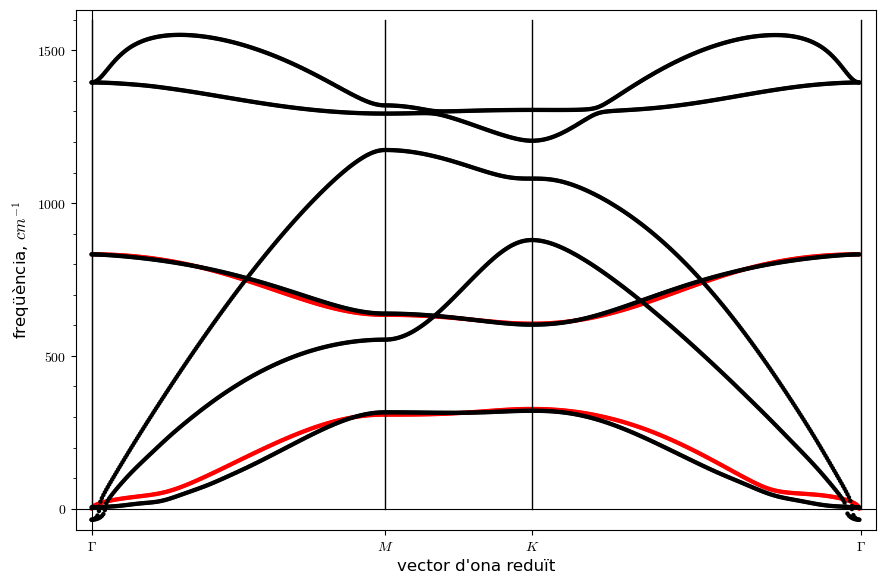

In [32]:
#Freqüències de Gamma a M (i les guardem com un dataframe). Calculem 200 punts en este interval
freq_perp_planol_Gamma_a_M=real_part(sqrt(np.linalg.eigvals(\
     np.array([D_zz4ts.subs(Solucions4ts, a=1, q_x=x/199*pi, q_y=x/199*pi/sqrt(3),\
                    M_B=B.mass, M_N=N.mass).numpy(dtype='complex64') for x in range(200)]))))

DF_freq_perp_planol_Gamma_a_M=pd.DataFrame(freq_perp_planol_Gamma_a_M)

#Freqüències de M a K (i les guardem com un dataframe). Calculem 100 punts en este interval
freq_perp_planol_M_a_K=real_part(sqrt(np.linalg.eigvals(\
     np.array([D_zz4ts.subs(Solucions4ts, a=1, q_x=pi*(1+x/(3*99)), q_y=pi/sqrt(3)*(1-x/99),\
                    M_B=B.mass, M_N=N.mass).numpy(dtype='complex64') for x in range(100)]))))

DF_freq_perp_planol_M_a_K=pd.DataFrame(freq_perp_planol_M_a_K)

#Freqüències de K a Gamma (i les guardem com un dataframe). Calculem 124 punts en este interval
freq_perp_planol_K_a_Gamma=real_part(sqrt(np.linalg.eigvals(\
     np.array([D_zz4ts.subs(Solucions4ts, a=1, q_x=4*pi/3*(1-x/223), q_y=0,\
                    M_B=B.mass, M_N=N.mass).numpy(dtype='complex64') for x in range(224)]))))

DF_freq_perp_planol_K_a_Gamma=pd.DataFrame(freq_perp_planol_K_a_Gamma)

DF_freq_calculades_perp_planol=pd.concat([DF_freq_perp_planol_Gamma_a_M,DF_freq_perp_planol_M_a_K,\
                                    DF_freq_perp_planol_K_a_Gamma],ignore_index=True)
DF_freq_calculades_perp_planol
DF_freq_calculades_perp_planol.to_csv("freq_calculades_perp_planol4ts.dat", sep='\t', encoding='utf-8', header=False)

dades_calculades_perp_planol=loadtxt("freq_calculades_perp_planol4ts.dat")
dispersioZ4ts=(points(zip(dades_calculades_perp_planol[:200,0], dades_calculades_perp_planol[:200,1]), color="red")+\
points(zip(dades_calculades_perp_planol[:200,0], dades_calculades_perp_planol[:200,2]), color="red")+\
points(zip(dades_calculades_perp_planol[200:300,0], dades_calculades_perp_planol[200:300,1]), color="red")+\
points(zip(dades_calculades_perp_planol[200:300,0], dades_calculades_perp_planol[200:300,2]), color="red")+\
points(zip(dades_calculades_perp_planol[300:524,0], dades_calculades_perp_planol[300:524,1]), color="red")+\
points(zip(dades_calculades_perp_planol[300:524,0], dades_calculades_perp_planol[300:524,2]), color="red")+\
points(zip(dades[:524,0], dades[:524,1]), color="black") +\
points(zip(dades[524:1048,0], dades[524:1048,1]), color="black") +\
points(zip(dades[1048:1572,0], dades[1048:1572,1]), color="black") +\
points(zip(dades[1572:2096,0], dades[1572:2096,1]), color="black") +\
points(zip(dades[2096:2620,0], dades[2096:2620,1]), color="black") +\
points(zip(dades[2620:3144,0], dades[2620:3144,1]), color="black") +\
line([(0,0), (0,1600)],color="black")+\
line([(200,0), (200,1600)],color="black")+\
line([(300,0), (300,1600)],color="black")+\
line([(524,0), (524,1600)],color="black"))

show(dispersioZ4ts,figsize=9,ticks=[[0,200,300,524],500], tick_formatter=[[r"$\Gamma$","$M$", "$K$",r"$\Gamma$"],500],\
     axes_labels=['vector d\'ona reduït','freqüència, $cm^{-1}$'],axes_labels_size=1.2, frame=True)

In [33]:
save(dispersioZ4ts,figsize=9,ticks=[[0,200,300,524],500], tick_formatter=[[r"$\Gamma$","$M$", "$K$",r"$\Gamma$"],500],\
     axes_labels=['vector d\'ona reduït','freqüència, $cm^{-1}$'],axes_labels_size=1.,frame=True, filename="/home/casimir/Documents/Fisica/TFG/TFG-Semiconductores_2D/Grafiques/DisZ4ts.pdf")

### Numèricament

La idea ara es realitzar l'ajust a les dades experimentals numèricament, per a la qual cosa necessite la matriu com a array de numpy:

Al fitxer *freq.dat* tenim l'arrel quadrada dels valors propis d'esta matriu als punts q_x, q_y, de manera que per ajustar el valor de les constants emprarem que té que complir-se
$det(D-\lambda_i I)=0$ o, el que és el mateix, $eigval(D)-\lambda_i=0$

## Vibracions al pla del cristall

Vibracions dins del pla del cristall
En este cas tractem amb una matriu $4\times 4$, i per tant tenim 4 valors propis ($\omega^2$) en cada punt ($q_x$, $q_y$), que corresponen a quatre rames.

In [34]:
D1BN_xy=D1BN.matrix_from_rows_and_columns([0,1],[0,1])
D1NB_xy=D1NB.matrix_from_rows_and_columns([0,1],[0,1])

D2BB3ers_xy=D2BB3ers.matrix_from_rows_and_columns([0,1],[0,1])
D2NN3ers_xy=D2NN3ers.matrix_from_rows_and_columns([0,1],[0,1])

D2BB4ts_xy=D2BB4ts.matrix_from_rows_and_columns([0,1],[0,1])
D2NN4ts_xy=D2NN4ts.matrix_from_rows_and_columns([0,1],[0,1])


D3BN_xy=D3BN.matrix_from_rows_and_columns([0,1],[0,1])
D3NB_xy=D3NB.matrix_from_rows_and_columns([0,1],[0,1])
D4BN_xy=D4BN.matrix_from_rows_and_columns([0,1],[0,1])
D4NB_xy=D4NB.matrix_from_rows_and_columns([0,1],[0,1])

D3ers_xy=block_matrix([[D2BB3ers_xy, D1BN_xy+D3BN_xy],[D1NB_xy+D3NB_xy, D2NN3ers_xy]])

D4ts_xy=block_matrix([[D2BB4ts_xy, D1BN_xy+D3BN_xy+D4BN_xy],[D1NB_xy+D3NB_xy+D4NB_xy, D2NN4ts_xy]])

D3ers=block_matrix([[D2BB3ers, D1BN+D3BN],[D1NB+D3NB, D2NN3ers]])

In [35]:
D3ers_xy

[-3/2*sqrt(1/3)*phi1rBN*cos(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N) - 3/2*sqrt(1/3)*phi3rBN*cos(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N) + 3/2*sqrt(1/3)*phi1rBN*cos(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N) + 3/2*sqrt(1/3)*phi3rBN*cos(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N) + 1/4*(phi2rBB/M_B + 3*phi2tiBB/M_B)*e^(1/2*I*sqrt(3)*a*q_y + 1/2*I*a*q_x) + 1/4*(phi2rBB/M_B + 3*phi2tiBB/M_B)*e^(1/2*I*sqrt(3)*a*q_y - 1/2*I*a*q_x) + 1/4*(phi2rBB/M_B + 3*phi2tiBB/M_B)*e^(-1/2*I*sqrt(3)*a*q_y + 1/2*I*a*q_x) + 1/4*(phi2rBB/M_B + 3*phi2tiBB/M_B)*e^(-1/2*I*sqrt(3)*a*q_y - 1/2*I*a*q_x) + 1/2*phi1tiBN*sin(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N) + 1/2*phi3tiBN*sin(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N) + 1/2*phi1tiBN*sin(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N) + 1/2*phi3tiBN*sin(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N) + phi2rBB*e^(I*a*q_x)/M_B + phi2rBB*e^(-I*a*q_x)/M_B - phi1tiBN/sqrt(M_B*M_N) - phi3tiBN/sqrt(M_B*M_N) - 3*phi2rBB/M_B - 3*phi2tiBB/M_B                                                                                  1/4*(sqrt(3)*phi2rBB/M_B - sqrt(3)*phi2tiBB/M_B)*e^(1/2*I*sqrt(3)*a*q_y + 1/2*I*a*q_x) - 1/4*(sqrt(3)*phi2rBB/M_B - sqrt(3)*phi2tiBB/M_B)*e^(1/2*I*sqrt(3)*a*q_y - 1/2*I*a*q_x) - 1/4*(sqrt(3)*phi2rBB/M_B - sqrt(3)*phi2tiBB/M_B)*e^(-1/2*I*sqrt(3)*a*q_y + 1/2*I*a*q_x) + 1/4*(sqrt(3)*phi2rBB/M_B - sqrt(3)*phi2tiBB/M_B)*e^(-1/2*I*sqrt(3)*a*q_y - 1/2*I*a*q_x) - 3/2*sqrt(1/3)*phi1rBN*sin(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N) - 3/2*sqrt(1/3)*phi3tiBN*sin(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N) + 3/2*sqrt(1/3)*phi1rBN*sin(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N) + 3/2*sqrt(1/3)*phi3tiBN*sin(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N) - 1/2*phi1tiBN*cos(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N) - 1/2*phi3rBN*cos(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N) - 1/2*phi1tiBN*cos(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N) - 1/2*phi3rBN*cos(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N)|                                                                                                                                                                                                                               3/2*sqrt(1/3)*phi1rBN*cos(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N) + 1/2*(3*sqrt(1/3)*phi3rBN*cos(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N) - phi3tiBN*sin(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N))*e^(1/2*I*sqrt(3)*a*q_y + 1/2*I*a*q_x) - 1/2*(3*sqrt(1/3)*phi3rBN*cos(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N) + phi3tiBN*sin(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N))*e^(1/2*I*sqrt(3)*a*q_y - 3/2*I*a*q_x) - 1/2*(3*sqrt(1/3)*phi1rBN*cos(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N) + phi1tiBN*sin(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N))*e^(-I*a*q_x) + phi1tiBN*e^(1/2*I*sqrt(3)*a*q_y - 1/2*I*a*q_x)/sqrt(M_B*M_N) + phi3tiBN*e^(-1/2*I*sqrt(3)*a*q_y - 1/2*I*a*q_x)/sqrt(M_B*M_N) - 1/2*phi1tiBN*sin(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N)                                                                                                                                                                                                                                                                                                                                                               1/2*(3*sqrt(1/3)*phi3tiBN*sin(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N) + phi3rBN*cos(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N))*e^(1/2*I*sqrt(3)*a*q_y + 1/2*I*a*q_x) - 1/2*(3*sqrt(1/3)*phi3tiBN*sin(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N) - phi3rBN*cos(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N))*e^(1/2*I*sqrt(3)*a*q_y - 3/2*I*a*q_x) - 1/2*(3*sqrt(1/3)*phi1rBN*sin(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N) - phi1tiBN*cos(-arccos(-3/2*sqrt(1/3)))/sqrt(M_B*M_N))*e^(-I*a*q_x) + 3/2*sqrt(1/3)*phi1rBN*sin(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N) + 1/2*phi1tiBN*cos(-arccos(3/2*sqrt(1/3)))/sqrt(M_B*M_N)]
[                                                                                 1/4*(sqrt(3)*phi2rBB/M_B - sqrt(3)*phi2tiBB/M_B)*e^(1/2*I*sqrt(3)*a*q_y + 1/2*I*a*q_x) - 1/4*(sqrt(3)*phi2rBB/M_B - sqrt(3)*phi2tiBB/M_B)*e^(1/2*I*sqrt(3)*a*q_y - 1/2*I*a*q_x) - 1/4*(s

### Considerem sols fins als 3ers veïns

#### Al punt $\Gamma$

Fins 3ers veïns

Al punt $\Gamma$ obtinc 2 valors propis, de multiplicitat $2$ cadascun:

In [36]:
omega_Gamma_TO=1395
omega_Gamma_LO=1395
D_Gamma3ers_xy=D3ers_xy.subs(q_x=0,q_y=0)
show([D_Gamma3ers_xy.eigenvalues()[0], D_Gamma3ers_xy.eigenvalues()[2]])

[-3*(phi1rBN + phi1tiBN + phi3rBN + phi3tiBN)/sqrt(M_B*M_N), 0]

De manera que obtenim la següent equació:

In [37]:
Eq_Gamma_TO3ers=(D_Gamma3ers_xy.eigenvalues()[0]==omegaGammaTO**2)
Eq_Gamma_LO3ers=(D_Gamma3ers_xy.eigenvalues()[1]==omegaGammaLO**2)
show(Eq_Gamma_LO3ers)

-3*(phi1rBN + phi1tiBN + phi3rBN + phi3tiBN)/sqrt(M_B*M_N) == omegaGammaLO^2

```{note}
Per als punts $K$ i $M$, sagemath (mitjançant [maxima](https://maxima.sourceforge.io/)) no obté una expressió analítica però si abans simplifique el problema, supossant que els 2 àtoms de la base tenen la mateixa massa  ($M_N=M_B$), sí que obtenim una solució analítica, i després podem obtindre els valors propis correctes per al nostre model realitzant les substitucions pertinents als resultats obtessos (cada constant apareix sempre dividida per l'arrel quadrada de les masses pertinenets)
```

### Al punt $M$
En ($q_x=\pi/a,q_y=\pi/(\sqrt{3} a$)

In [38]:
D_M3ers_xy=D3ers_xy.subs(q_x=pi/a,q_y=pi/(sqrt(3)*a))

D_M3ers_xy_simplificada=D_M3ers_xy.subs(M_N=M_B)

Valors_propis_M3ers=D_M3ers_xy_simplificada.eigenvalues()

Valors_propis_en_M3ers=[M_B*Valors_propis_M3ers[i].subs(
    phi1rBN=phi1rBN/sqrt(M_N*M_B), phi1tiBN=phi1tiBN/sqrt(M_N*M_B), 
    phi2rBB=phi2rBB/M_B, phi2tiBB=phi2tiBB/M_B,
    phi2rNN=phi2rNN/M_N, phi2tiNN=phi2tiNN/M_N,
    phi3rBN=phi3rBN/sqrt(M_N*M_B), phi3tiBN=phi3tiBN/sqrt(M_N*M_B),) for i in range(4)]
    #phi4rBN=phi4rBN/sqrt(M_N*M_B), phi4tiBN=phi4tiBN/sqrt(M_N*M_B)


omega_M_LO=1320
omega_M_TO=1293
omega_M_LA=1174
omega_M_TA=553
#Comprobem que sí són els valors propis:
#[det(D_M3ers_xy-Valors_propis_en_M3ers[i]) for i in range(4)]
for i in range(4):
    show(Valors_propis_en_M3ers[i].expand())

-1/2*sqrt(9*phi1rBN^2/(M_B*M_N) - 6*phi1rBN*phi1tiBN/(M_B*M_N) + phi1tiBN^2/(M_B*M_N) + 4*phi2rBB^2/M_B^2 - 8*phi2rBB*phi2rNN/(M_B*M_N) + 4*phi2rNN^2/M_N^2 + 24*phi2rBB*phi2tiBB/M_B^2 - 24*phi2rNN*phi2tiBB/(M_B*M_N) + 36*phi2tiBB^2/M_B^2 - 24*phi2rBB*phi2tiNN/(M_B*M_N) + 24*phi2rNN*phi2tiNN/M_N^2 - 72*phi2tiBB*phi2tiNN/(M_B*M_N) + 36*phi2tiNN^2/M_N^2 - 18*phi1rBN*phi3rBN/(M_B*M_N) + 6*phi1tiBN*phi3rBN/(M_B*M_N) + 9*phi3rBN^2/(M_B*M_N) - 18*phi1rBN*phi3tiBN/(M_B*M_N) + 6*phi1tiBN*phi3tiBN/(M_B*M_N) + 18*phi3rBN*phi3tiBN/(M_B*M_N) + 9*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - phi2rBB/M_B - phi2rNN/M_N - 3*phi2tiBB/M_B - 3*phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

1/2*sqrt(9*phi1rBN^2/(M_B*M_N) - 6*phi1rBN*phi1tiBN/(M_B*M_N) + phi1tiBN^2/(M_B*M_N) + 4*phi2rBB^2/M_B^2 - 8*phi2rBB*phi2rNN/(M_B*M_N) + 4*phi2rNN^2/M_N^2 + 24*phi2rBB*phi2tiBB/M_B^2 - 24*phi2rNN*phi2tiBB/(M_B*M_N) + 36*phi2tiBB^2/M_B^2 - 24*phi2rBB*phi2tiNN/(M_B*M_N) + 24*phi2rNN*phi2tiNN/M_N^2 - 72*phi2tiBB*phi2tiNN/(M_B*M_N) + 36*phi2tiNN^2/M_N^2 - 18*phi1rBN*phi3rBN/(M_B*M_N) + 6*phi1tiBN*phi3rBN/(M_B*M_N) + 9*phi3rBN^2/(M_B*M_N) - 18*phi1rBN*phi3tiBN/(M_B*M_N) + 6*phi1tiBN*phi3tiBN/(M_B*M_N) + 18*phi3rBN*phi3tiBN/(M_B*M_N) + 9*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - phi2rBB/M_B - phi2rNN/M_N - 3*phi2tiBB/M_B - 3*phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

-1/2*sqrt(phi1rBN^2/(M_B*M_N) - 6*phi1rBN*phi1tiBN/(M_B*M_N) + 9*phi1tiBN^2/(M_B*M_N) + 36*phi2rBB^2/M_B^2 - 72*phi2rBB*phi2rNN/(M_B*M_N) + 36*phi2rNN^2/M_N^2 + 24*phi2rBB*phi2tiBB/M_B^2 - 24*phi2rNN*phi2tiBB/(M_B*M_N) + 4*phi2tiBB^2/M_B^2 - 24*phi2rBB*phi2tiNN/(M_B*M_N) + 24*phi2rNN*phi2tiNN/M_N^2 - 8*phi2tiBB*phi2tiNN/(M_B*M_N) + 4*phi2tiNN^2/M_N^2 + 6*phi1rBN*phi3rBN/(M_B*M_N) - 18*phi1tiBN*phi3rBN/(M_B*M_N) + 9*phi3rBN^2/(M_B*M_N) + 6*phi1rBN*phi3tiBN/(M_B*M_N) - 18*phi1tiBN*phi3tiBN/(M_B*M_N) + 18*phi3rBN*phi3tiBN/(M_B*M_N) + 9*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi2rBB/M_B - 3*phi2rNN/M_N - phi2tiBB/M_B - phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

1/2*sqrt(phi1rBN^2/(M_B*M_N) - 6*phi1rBN*phi1tiBN/(M_B*M_N) + 9*phi1tiBN^2/(M_B*M_N) + 36*phi2rBB^2/M_B^2 - 72*phi2rBB*phi2rNN/(M_B*M_N) + 36*phi2rNN^2/M_N^2 + 24*phi2rBB*phi2tiBB/M_B^2 - 24*phi2rNN*phi2tiBB/(M_B*M_N) + 4*phi2tiBB^2/M_B^2 - 24*phi2rBB*phi2tiNN/(M_B*M_N) + 24*phi2rNN*phi2tiNN/M_N^2 - 8*phi2tiBB*phi2tiNN/(M_B*M_N) + 4*phi2tiNN^2/M_N^2 + 6*phi1rBN*phi3rBN/(M_B*M_N) - 18*phi1tiBN*phi3rBN/(M_B*M_N) + 9*phi3rBN^2/(M_B*M_N) + 6*phi1rBN*phi3tiBN/(M_B*M_N) - 18*phi1tiBN*phi3tiBN/(M_B*M_N) + 18*phi3rBN*phi3tiBN/(M_B*M_N) + 9*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi2rBB/M_B - 3*phi2rNN/M_N - phi2tiBB/M_B - phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

Podem observar que els valors propis en M 0 i 1 (així com 2 i 3) difereixen en una arrel quadrada (negativa i per tant amb valor propi corresponent menor per a 0 i 2).
Per una altra banda els termes de fora de l'arrel sols difereixen en 2 i 3 respecte els de 1 i 2 que els termes $\phi_{2,r}$ ($BB$ i $NN$) van multiplicats pel factor 3 en el cas de $2$ i $3$ mentre que en $0$ i $1$ son els termes $\phi_{2,ti}$ els que van multiplicats per 3.

Supossant que les constants de força radials són més grans que les transversals per assignar cada valor propi a cada rama, puc concloure que els dos primers valors propis corresponen al menor i al major respectivament. Els 3 i 4ts don intermijos, essent el 4t major que el tercer, per tant

In [39]:
Eq_M_LA3ers = (Valors_propis_en_M3ers[0].expand() == omegaMTA^2)
Eq_M_TA3ers = (Valors_propis_en_M3ers[1].expand() == omegaMLO^2)
Eq_M_TO3ers = (Valors_propis_en_M3ers[2].expand() == omegaMLA^2)
Eq_M_LO3ers = (Valors_propis_en_M3ers[3].expand() == omegaMTO^2)

#Eq_M_LA3ers = (Valors_propis_en_M3ers[0].expand() == omegaMTA^2)
#Eq_M_LO3ers = (Valors_propis_en_M3ers[1].expand() == omegaMLO^2)
#Eq_M_TA3ers = (Valors_propis_en_M3ers[2].expand() == omegaMLA^2)
#Eq_M_TO3ers = (Valors_propis_en_M3ers[3].expand() == omegaMTO^2)

show(Eq_M_LA3ers)
show(Eq_M_LO3ers)
show(Eq_M_TA3ers)
show(Eq_M_TO3ers)

#Eq_M_TA_mes_M_LO3ers=(Eq_M_TA3ers + Eq_M_LO3ers)
#show(Eq_M_TA_mes_M_LO3ers)
#Eq_M_LA_mes_M_TO3ers=(Eq_M_LA3ers + Eq_M_TO3ers)
#show(Eq_M_LA_mes_M_TO3ers)
#Eq_M_LO_menys_TA3ers_quadrat=((Eq_M_LO3ers-Eq_M_TA3ers)**2).expand()
#show(Eq_M_LO_menys_TA3ers_quadrat)
#Eq_M_TO_menys_LA3ers_quadrat=((Eq_M_TO3ers-Eq_M_LA3ers)**2).expand()
#show(Eq_M_TO_menys_LA3ers_quadrat)
#Fem notar que la suma de tots els valors propis en $M$ compleix l'equació:
#(3*Eq_M_LA_mes_M_TO3ers-Eq_M_TA_mes_M_LO3ers).subs(solve(Eq_Gamma_TO3ers,phi3rBN)).expand()
#(Eq_M_LA_mes_M_TO-3*Eq_M_TA_mes_M_LO).subs(solve(Eq_Gamma_TO,phi3rBN)).expand()

#show(Eq_M_TA3ers+Eq_M_LO3ers)
#show(Eq_M_LA3ers+Eq_M_TO3ers)

-1/2*sqrt(9*phi1rBN^2/(M_B*M_N) - 6*phi1rBN*phi1tiBN/(M_B*M_N) + phi1tiBN^2/(M_B*M_N) + 4*phi2rBB^2/M_B^2 - 8*phi2rBB*phi2rNN/(M_B*M_N) + 4*phi2rNN^2/M_N^2 + 24*phi2rBB*phi2tiBB/M_B^2 - 24*phi2rNN*phi2tiBB/(M_B*M_N) + 36*phi2tiBB^2/M_B^2 - 24*phi2rBB*phi2tiNN/(M_B*M_N) + 24*phi2rNN*phi2tiNN/M_N^2 - 72*phi2tiBB*phi2tiNN/(M_B*M_N) + 36*phi2tiNN^2/M_N^2 - 18*phi1rBN*phi3rBN/(M_B*M_N) + 6*phi1tiBN*phi3rBN/(M_B*M_N) + 9*phi3rBN^2/(M_B*M_N) - 18*phi1rBN*phi3tiBN/(M_B*M_N) + 6*phi1tiBN*phi3tiBN/(M_B*M_N) + 18*phi3rBN*phi3tiBN/(M_B*M_N) + 9*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - phi2rBB/M_B - phi2rNN/M_N - 3*phi2tiBB/M_B - 3*phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N)) == omegaMTA^2

1/2*sqrt(phi1rBN^2/(M_B*M_N) - 6*phi1rBN*phi1tiBN/(M_B*M_N) + 9*phi1tiBN^2/(M_B*M_N) + 36*phi2rBB^2/M_B^2 - 72*phi2rBB*phi2rNN/(M_B*M_N) + 36*phi2rNN^2/M_N^2 + 24*phi2rBB*phi2tiBB/M_B^2 - 24*phi2rNN*phi2tiBB/(M_B*M_N) + 4*phi2tiBB^2/M_B^2 - 24*phi2rBB*phi2tiNN/(M_B*M_N) + 24*phi2rNN*phi2tiNN/M_N^2 - 8*phi2tiBB*phi2tiNN/(M_B*M_N) + 4*phi2tiNN^2/M_N^2 + 6*phi1rBN*phi3rBN/(M_B*M_N) - 18*phi1tiBN*phi3rBN/(M_B*M_N) + 9*phi3rBN^2/(M_B*M_N) + 6*phi1rBN*phi3tiBN/(M_B*M_N) - 18*phi1tiBN*phi3tiBN/(M_B*M_N) + 18*phi3rBN*phi3tiBN/(M_B*M_N) + 9*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi2rBB/M_B - 3*phi2rNN/M_N - phi2tiBB/M_B - phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N)) == omegaMTO^2

1/2*sqrt(9*phi1rBN^2/(M_B*M_N) - 6*phi1rBN*phi1tiBN/(M_B*M_N) + phi1tiBN^2/(M_B*M_N) + 4*phi2rBB^2/M_B^2 - 8*phi2rBB*phi2rNN/(M_B*M_N) + 4*phi2rNN^2/M_N^2 + 24*phi2rBB*phi2tiBB/M_B^2 - 24*phi2rNN*phi2tiBB/(M_B*M_N) + 36*phi2tiBB^2/M_B^2 - 24*phi2rBB*phi2tiNN/(M_B*M_N) + 24*phi2rNN*phi2tiNN/M_N^2 - 72*phi2tiBB*phi2tiNN/(M_B*M_N) + 36*phi2tiNN^2/M_N^2 - 18*phi1rBN*phi3rBN/(M_B*M_N) + 6*phi1tiBN*phi3rBN/(M_B*M_N) + 9*phi3rBN^2/(M_B*M_N) - 18*phi1rBN*phi3tiBN/(M_B*M_N) + 6*phi1tiBN*phi3tiBN/(M_B*M_N) + 18*phi3rBN*phi3tiBN/(M_B*M_N) + 9*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - phi2rBB/M_B - phi2rNN/M_N - 3*phi2tiBB/M_B - 3*phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N)) == omegaMLO^2

-1/2*sqrt(phi1rBN^2/(M_B*M_N) - 6*phi1rBN*phi1tiBN/(M_B*M_N) + 9*phi1tiBN^2/(M_B*M_N) + 36*phi2rBB^2/M_B^2 - 72*phi2rBB*phi2rNN/(M_B*M_N) + 36*phi2rNN^2/M_N^2 + 24*phi2rBB*phi2tiBB/M_B^2 - 24*phi2rNN*phi2tiBB/(M_B*M_N) + 4*phi2tiBB^2/M_B^2 - 24*phi2rBB*phi2tiNN/(M_B*M_N) + 24*phi2rNN*phi2tiNN/M_N^2 - 8*phi2tiBB*phi2tiNN/(M_B*M_N) + 4*phi2tiNN^2/M_N^2 + 6*phi1rBN*phi3rBN/(M_B*M_N) - 18*phi1tiBN*phi3rBN/(M_B*M_N) + 9*phi3rBN^2/(M_B*M_N) + 6*phi1rBN*phi3tiBN/(M_B*M_N) - 18*phi1tiBN*phi3tiBN/(M_B*M_N) + 18*phi3rBN*phi3tiBN/(M_B*M_N) + 9*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi2rBB/M_B - 3*phi2rNN/M_N - phi2tiBB/M_B - phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N)) == omegaMLA^2

### Al punt $K$ 
En $\left(k_x=\frac{4\pi}{3a}, k_y=0\right)$

In [40]:
omega_K_LO=1305
omega_K_TO=1293
omega_K_LA=1080
omega_K_TA=879

#sqrt(omega_K_LO**2+omega_K_TA**2-omega_K_LA)

D_K3ers_xy=D3ers_xy.subs(q_x=4*pi/(3*a),q_y=0)# phi4tiBN=-phi4rBN)
D_K3ers_xy_simplificada=D_K3ers_xy.subs(M_N=M_B)
Valors_propis_K3ers=D_K3ers_xy_simplificada.eigenvalues()

Valors_propis_en_K3ers=[M_B*Valors_propis_K3ers[i].expand().subs(
    phi1rBN=phi1rBN/sqrt(M_N*M_B), phi1tiBN=phi1tiBN/sqrt(M_N*M_B), 
    phi2rBB=phi2rBB/M_B, phi2tiBB=phi2tiBB/M_B,
    phi2rNN=phi2rNN/M_N, phi2tiNN=phi2tiNN/M_N,
    phi3rBN=phi3rBN/sqrt(M_N*M_B), phi3tiBN=phi3tiBN/sqrt(M_N*M_B)) for i in range(4)]
    #phi4rBN=phi4rBN/sqrt(M_N*M_B), phi4tiBN=phi4tiBN/sqrt(M_N*M_B)) for i in range(4)]

#Comprobem que sí són els valors propis:
#[det(D_K_xy-Valors_propis_en_K[i]) for i in range(4)]
for i in range(4):
    show(Valors_propis_en_K3ers[i].expand())

-3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 9/2*phi2rNN/M_N - 9/2*phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

-3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 9/2*phi2rBB/M_B - 9/2*phi2tiBB/M_B - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

-3/4*sqrt(4*phi1rBN^2/(M_B*M_N) - 8*phi1rBN*phi1tiBN/(M_B*M_N) + 4*phi1tiBN^2/(M_B*M_N) + 9*phi2rBB^2/M_B^2 - 18*phi2rBB*phi2rNN/(M_B*M_N) + 9*phi2rNN^2/M_N^2 + 18*phi2rBB*phi2tiBB/M_B^2 - 18*phi2rNN*phi2tiBB/(M_B*M_N) + 9*phi2tiBB^2/M_B^2 - 18*phi2rBB*phi2tiNN/(M_B*M_N) + 18*phi2rNN*phi2tiNN/M_N^2 - 18*phi2tiBB*phi2tiNN/(M_B*M_N) + 9*phi2tiNN^2/M_N^2 + 8*phi1rBN*phi3rBN/(M_B*M_N) - 8*phi1tiBN*phi3rBN/(M_B*M_N) + 4*phi3rBN^2/(M_B*M_N) - 8*phi1rBN*phi3tiBN/(M_B*M_N) + 8*phi1tiBN*phi3tiBN/(M_B*M_N) - 8*phi3rBN*phi3tiBN/(M_B*M_N) + 4*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 9/4*phi2rBB/M_B - 9/4*phi2rNN/M_N - 9/4*phi2tiBB/M_B - 9/4*phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

3/4*sqrt(4*phi1rBN^2/(M_B*M_N) - 8*phi1rBN*phi1tiBN/(M_B*M_N) + 4*phi1tiBN^2/(M_B*M_N) + 9*phi2rBB^2/M_B^2 - 18*phi2rBB*phi2rNN/(M_B*M_N) + 9*phi2rNN^2/M_N^2 + 18*phi2rBB*phi2tiBB/M_B^2 - 18*phi2rNN*phi2tiBB/(M_B*M_N) + 9*phi2tiBB^2/M_B^2 - 18*phi2rBB*phi2tiNN/(M_B*M_N) + 18*phi2rNN*phi2tiNN/M_N^2 - 18*phi2tiBB*phi2tiNN/(M_B*M_N) + 9*phi2tiNN^2/M_N^2 + 8*phi1rBN*phi3rBN/(M_B*M_N) - 8*phi1tiBN*phi3rBN/(M_B*M_N) + 4*phi3rBN^2/(M_B*M_N) - 8*phi1rBN*phi3tiBN/(M_B*M_N) + 8*phi1tiBN*phi3tiBN/(M_B*M_N) - 8*phi3rBN*phi3tiBN/(M_B*M_N) + 4*phi3tiBN^2/(M_B*M_N)) - 3/2*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 9/4*phi2rBB/M_B - 9/4*phi2rNN/M_N - 9/4*phi2tiBB/M_B - 9/4*phi2tiNN/M_N - 3/2*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3/2*phi3tiBN/(sqrt(M_B)*sqrt(M_N))

In [41]:
#Comprobem que sí són els valors propis:
[det(D_K3ers_xy-Valors_propis_en_K3ers[i]) for i in range(4)]

[0, 0, 0, 0]

Emprant un argument anàleg a l'emprat per als valors propis en $M$ assignem cada valor propi a cadascuna de les rames, de manera que:

In [42]:
Eq_K_LO3ers = (Valors_propis_en_K3ers[0].expand() == omegaKLO^2)
Eq_K_LA3ers = (Valors_propis_en_K3ers[1].expand() == omegaKLA^2)
Eq_K_TA3ers = (Valors_propis_en_K3ers[2].expand() == omegaKTA^2)
Eq_K_TO3ers = (Valors_propis_en_K3ers[3].expand() == omegaKTO^2)

show(Eq_K_TO3ers+Eq_K_LO3ers)
show(Eq_K_TA3ers+Eq_K_LA3ers)

show(omega_K_LO^2+omega_K_TO^2-(omega_K_TA^2+omega_K_LA^2))
#show(omega_K_TA^2+omega_K_LA^2-(omega_K_LO^2+omega_K_TO^2))
#Eq_KTA_mes_KLO3ers=(Eq_K_TA3ers + Eq_K_LO3ers)
#Eq_KLA_mes_KTO3ers=(Eq_K_LA3ers + Eq_K_TO3ers)

#show(Eq_K_LA3ers)
#show(Eq_K_TO3ers)
#show(Eq_K_TA3ers)
#show(Eq_K_LO3ers)

#Eq_KLO_menys_KTA_quadrat3ers=((Eq_K_LO3ers-Eq_K_TA3ers)**2).expand()
#Eq_KTO_menys_KLA_quadrat3ers=((Eq_K_TO3ers-Eq_K_LA3ers)**2).expand()

#Comprobem que sí són els valors propis:
#show(Eq_K_LA3ers.subs(constants).expand())
#show(Eq_K_TO3ers.subs(constants).expand())

#show(Eq_KLA_mes_KTO3ers.expand())
#show(Eq_KTA_mes_KLO3ers.expand())
#show(Eq_KLO_menys_KTA_quadrat3ers)
#show(Eq_KTO_menys_KLA_quadrat3ers)

3/4*sqrt(4*phi1rBN^2/(M_B*M_N) - 8*phi1rBN*phi1tiBN/(M_B*M_N) + 4*phi1tiBN^2/(M_B*M_N) + 9*phi2rBB^2/M_B^2 - 18*phi2rBB*phi2rNN/(M_B*M_N) + 9*phi2rNN^2/M_N^2 + 18*phi2rBB*phi2tiBB/M_B^2 - 18*phi2rNN*phi2tiBB/(M_B*M_N) + 9*phi2tiBB^2/M_B^2 - 18*phi2rBB*phi2tiNN/(M_B*M_N) + 18*phi2rNN*phi2tiNN/M_N^2 - 18*phi2tiBB*phi2tiNN/(M_B*M_N) + 9*phi2tiNN^2/M_N^2 + 8*phi1rBN*phi3rBN/(M_B*M_N) - 8*phi1tiBN*phi3rBN/(M_B*M_N) + 4*phi3rBN^2/(M_B*M_N) - 8*phi1rBN*phi3tiBN/(M_B*M_N) + 8*phi1tiBN*phi3tiBN/(M_B*M_N) - 8*phi3rBN*phi3tiBN/(M_B*M_N) + 4*phi3tiBN^2/(M_B*M_N)) - 3*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 9/4*phi2rBB/M_B - 27/4*phi2rNN/M_N - 9/4*phi2tiBB/M_B - 27/4*phi2tiNN/M_N - 3*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi3tiBN/(sqrt(M_B)*sqrt(M_N)) == omegaKLO^2 + omegaKTO^2

-3/4*sqrt(4*phi1rBN^2/(M_B*M_N) - 8*phi1rBN*phi1tiBN/(M_B*M_N) + 4*phi1tiBN^2/(M_B*M_N) + 9*phi2rBB^2/M_B^2 - 18*phi2rBB*phi2rNN/(M_B*M_N) + 9*phi2rNN^2/M_N^2 + 18*phi2rBB*phi2tiBB/M_B^2 - 18*phi2rNN*phi2tiBB/(M_B*M_N) + 9*phi2tiBB^2/M_B^2 - 18*phi2rBB*phi2tiNN/(M_B*M_N) + 18*phi2rNN*phi2tiNN/M_N^2 - 18*phi2tiBB*phi2tiNN/(M_B*M_N) + 9*phi2tiNN^2/M_N^2 + 8*phi1rBN*phi3rBN/(M_B*M_N) - 8*phi1tiBN*phi3rBN/(M_B*M_N) + 4*phi3rBN^2/(M_B*M_N) - 8*phi1rBN*phi3tiBN/(M_B*M_N) + 8*phi1tiBN*phi3tiBN/(M_B*M_N) - 8*phi3rBN*phi3tiBN/(M_B*M_N) + 4*phi3tiBN^2/(M_B*M_N)) - 3*phi1rBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi1tiBN/(sqrt(M_B)*sqrt(M_N)) - 27/4*phi2rBB/M_B - 9/4*phi2rNN/M_N - 27/4*phi2tiBB/M_B - 9/4*phi2tiNN/M_N - 3*phi3rBN/(sqrt(M_B)*sqrt(M_N)) - 3*phi3tiBN/(sqrt(M_B)*sqrt(M_N)) == omegaKLA^2 + omegaKTA^2

1435833

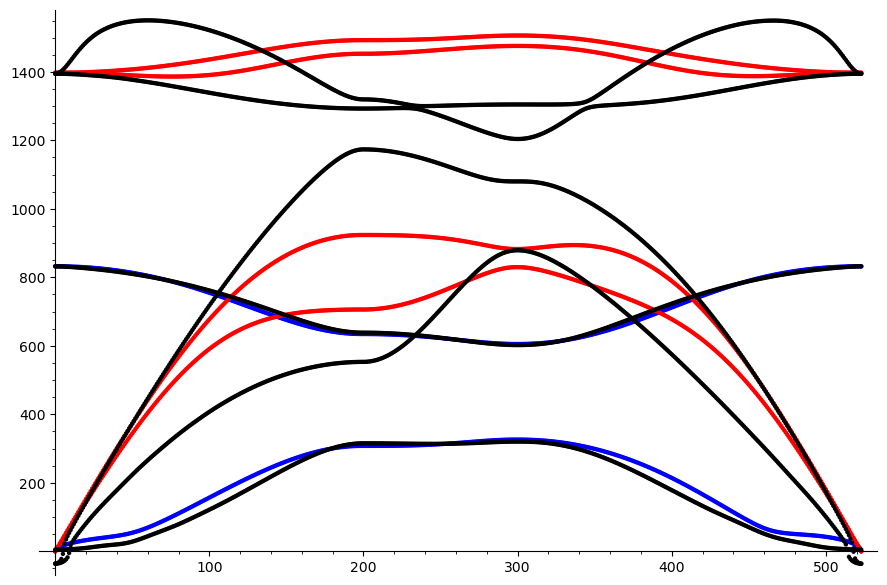

[phi1rBN == -5452254,
 phi1tiBN == -2187367,
 phi2rBB == -1623685,
 phi2tiBB == -1262775,
 phi2rNN == 1366331,
 phi2tiNN == -752386,
 phi3rBN == -60596,
 phi3tiBN == -309353]

In [43]:
valors_numerics_pla_emprats=[omegaGammaTO==omega_Gamma_TO,\
                             omegaMLO==omega_M_LO,\
                             omegaMTO==omega_M_TO-sqrt(362583/2),\
                             omegaMLA==omega_M_LA+sqrt(362583/2),\
                             omegaMTA==omega_M_TA,\
                             omegaKLO==omega_K_LO,\
                             omegaKTO==omega_K_TO,\
                             omegaKLA==omega_K_LA,\
                             omegaKTA==omega_K_TA,\
                             M_B==B.mass, M_N==N.mass \
                            ]
Equacionspla3ers=[Eq_Gamma_TO3ers.subs(valors_numerics_pla_emprats),\
                  Eq_M_LO3ers.subs(valors_numerics_pla_emprats),\
                  Eq_M_TO3ers.subs(valors_numerics_pla_emprats),\
                  Eq_M_LA3ers.subs(valors_numerics_pla_emprats),\
                  Eq_M_TA3ers.subs(valors_numerics_pla_emprats),\
                  Eq_K_LO3ers.subs(valors_numerics_pla_emprats),\
                  Eq_K_TO3ers.subs(valors_numerics_pla_emprats),\
                  Eq_K_LA3ers.subs(valors_numerics_pla_emprats),\
                  Eq_K_TA3ers.subs(valors_numerics_pla_emprats)]

solucionspla3ers=minimize(norm(vector((Equacionspla3ers))),\
                          [-1400000.,1.,1.,1.,1.,1.,1.,1.])
#\[-140000,-300000.,1.,1.,1.,1.,1.,1.])
Solucionspla3ers=[phi1rBN==round(solucionspla3ers[0]),\
                  phi1tiBN==round(solucionspla3ers[1]),\
                  phi2rBB==round(solucionspla3ers[2]),\
                  phi2tiBB==round(solucionspla3ers[3]),\
                  phi2rNN==round(solucionspla3ers[4]),\
                  phi2tiNN==round(solucionspla3ers[5]),\
                  phi3rBN==round(solucionspla3ers[6]),\
                  phi3tiBN==round(solucionspla3ers[7])]
                  
#Solucionspla3ers
#Freqüències de Gamma a M (i les guardem com un dataframe). Calculem 200 punts en este interval
freq_planol_Gamma_a_M=real_part(sqrt(np.linalg.eigvals(\
     np.array([D3ers_xy.subs(Solucionspla3ers, a=1, q_x=x/199*pi, q_y=x/199*pi/sqrt(3),\
                    M_B=B.mass, M_N=N.mass).numpy(dtype='complex64') for x in range(200)]))))

DF_freq_planol_Gamma_a_M=pd.DataFrame(freq_planol_Gamma_a_M)

#Freqüències de M a K (i les guardem com un dataframe). Calculem 100 punts en este interval
freq_planol_M_a_K=real_part(sqrt(np.linalg.eigvals(\
     np.array([D3ers_xy.subs(Solucionspla3ers, a=1, q_x=pi*(1+x/(3*99)), q_y=pi/sqrt(3)*(1-x/99),\
                    M_B=B.mass, M_N=N.mass).numpy(dtype='complex64') for x in range(100)]))))

DF_freq_planol_M_a_K=pd.DataFrame(freq_planol_M_a_K)

#Freqüències de K a Gamma (i les guardem com un dataframe). Calculem 124 punts en este interval

freq_planol_K_a_Gamma=real_part(sqrt(np.linalg.eigvals(\
     np.array([D3ers_xy.subs(Solucionspla3ers, a=1, q_x=4*pi/3*(1-x/223), q_y=0,\
                    M_B=B.mass, M_N=N.mass).numpy(dtype='complex64') for x in range(224)]))))

DF_freq_planol_K_a_Gamma=pd.DataFrame(freq_planol_K_a_Gamma)

DF_freq_calculades_planol=pd.concat([DF_freq_planol_Gamma_a_M,DF_freq_planol_M_a_K,\
                                    DF_freq_planol_K_a_Gamma],ignore_index=True)

DF_freq_calculades_planol.to_csv("freq_calculades_planol.dat",\
                                 sep='\t', encoding='utf-8', header=False)

dades_calculades_planol=loadtxt("freq_calculades_planol.dat")
show(\
points(zip(dades_calculades_perp_planol[:200,0], dades_calculades_perp_planol[:200,1]), color="blue")+\
points(zip(dades_calculades_perp_planol[:200,0], dades_calculades_perp_planol[:200,2]), color="blue")+\
points(zip(dades_calculades_perp_planol[200:300,0], dades_calculades_perp_planol[200:300,1]), color="blue")+\
points(zip(dades_calculades_perp_planol[200:300,0], dades_calculades_perp_planol[200:300,2]), color="blue")+\
points(zip(dades_calculades_perp_planol[300:524,0], dades_calculades_perp_planol[300:524,1]), color="blue")+\
points(zip(dades_calculades_perp_planol[300:524,0], dades_calculades_perp_planol[300:524,2]), color="blue")+\
points(zip(dades_calculades_planol[:200,0], dades_calculades_planol[:200,1]), color="red")+\
points(zip(dades_calculades_planol[:200,0], dades_calculades_planol[:200,2]), color="red")+\
points(zip(dades_calculades_planol[:200,0], dades_calculades_planol[:200,3]), color="red")+\
points(zip(dades_calculades_planol[:200,0], dades_calculades_planol[:200,4]), color="red")+\
points(zip(dades_calculades_planol[200:300,0], dades_calculades_planol[200:300,1]), color="red")+\
points(zip(dades_calculades_planol[200:300,0], dades_calculades_planol[200:300,2]), color="red")+\
points(zip(dades_calculades_planol[200:300,0], dades_calculades_planol[200:300,3]), color="red")+\
points(zip(dades_calculades_planol[200:300,0], dades_calculades_planol[200:300,4]), color="red")+\
points(zip(dades_calculades_planol[300:524,0], dades_calculades_planol[300:524,1]), color="red")+\
points(zip(dades_calculades_planol[300:524,0], dades_calculades_planol[300:524,2]), color="red")+\
points(zip(dades_calculades_planol[300:524,0], dades_calculades_planol[300:524,3]), color="red")+\
points(zip(dades_calculades_planol[300:524,0], dades_calculades_planol[300:524,4]), color="red")+\
points(zip(dades[:524,0], dades[:524,1]), color="black") +\
points(zip(dades[524:1048,0], dades[524:1048,1]), color="black") +\
points(zip(dades[1048:1572,0], dades[1048:1572,1]), color="black") +\
points(zip(dades[1572:2096,0], dades[1572:2096,1]), color="black") +\
points(zip(dades[2096:2620,0], dades[2096:2620,1]), color="black") +\
points(zip(dades[2620:3144,0], dades[2620:3144,1]), color="black")     
     ,figsize=9)
show(Solucionspla3ers)